In [0]:
!pip3 install tensorflow-gpu==1.13.1
!pip3 install keras==2.1.1
!pip3 install PyDrive

import sys
import os
import shutil
import time
import datetime
import re
import random
import zipfile
import tarfile
import bz2
import h5py
import cv2
import keras
import tensorflow as tf
import numpy as np

from functools import wraps
from itertools import zip_longest
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from google.colab import auth, files, drive
from natsort import natsorted
from tensorflow.python.client.device_lib import list_local_devices
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

np.set_printoptions(threshold=sys.maxsize)
random.seed(1024)

print(f'Tensorflow version = {tf.__version__}')
print(f'Keras version on top of tersorflow = {tf.keras.__version__}')
print(f'Keras version = {keras.__version__}')
print('GPU:')
print(list_local_devices())

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Tensorflow version = 1.13.1
Keras version on top of tersorflow = 2.2.4-tf
Keras version = 2.1.1
GPU:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17751161557982849894
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12689720913586818224
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17445074995475304084
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15955974554
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10299803235724989382
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
drive.mount('/content/gdrive')

In [0]:
input_shape = (img_height, img_width, img_depth) = (56, 56, 1)

In [0]:
def config_viola_jones():
    fpath = ('/content/gdrive/My Drive/datasets /'
             'facial recognition/viola-jones-xmlfile/'
             'haarcascade_frontalface_defalut.xml')
    face_detector = cv2.CascadeClassifier(fpath)
    return face_detector

face_detector = config_viola_jones()

In [0]:
def detect_face(imgpath, face_detector):
    img = cv2.imread(imgpath)
    gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    face_coords = face_detector.detectMultiScale(gray,
                                                scaleFactor=1.2,
                                                minNeighbors=10)
    new_imgpath = "/content/tmp/face.jpg"
    for x_start, y_start, width, height in face_coords:
        cv2.imwrite(filename=new_imgpath,
                    img=img[y_start:y_start+height, x_start:x_start+width])
    return new_imgpath

In [0]:
os.mkdir('/content/tmp')

In [0]:
def display_time(start_time):
    return ('Duration = {}'.format(time.strftime \
                                ('%H hours, %M minutes, %S seconds', 
                                 time.gmtime(time.time()-start_time))))

In [0]:
class Extractor:
    """Abstract the extraction of the the .zip and .tar
    files from my gdrive account
    """
    def __init__(self, new_base_dir):
        self.new_base_dir = new_base_dir
        
    def mk_new_dir(self, compressed_file, new_base_dir, dataset):
        try:
            os.mkdir(new_base_dir)
        except FileExistsError as error:
            pass
        new_dst_dir = os.path.join(new_base_dir, dataset)
        try:
            os.mkdir(new_dst_dir)
        except FileExistsError as error:
            pass
        return new_dst_dir
    
    def inform(self, dataset, new_dst_dir):
        print(f'Extracted {dataset} dataset in directory {new_dst_dir}')
        
    def extract_zipfile(self, zipfile_path, dataset, flag_display_info, 
                        inner_name=None):
        new_dst_dir = self.mk_new_dir(zipfile_path, self.new_base_dir, dataset)
        with zipfile.ZipFile(zipfile_path, 'r') as f:
            f.extractall(new_dst_dir)
        if flag_display_info:
            self.inform(dataset, new_dst_dir)
        if inner_name is not None:
            new_dst_dir = os.path.join(new_dst_dir, inner_name)
        return new_dst_dir 
    
    def extract_tarfile(self, tarfile_path, dataset, flag_display_info,
                        inner_name=None):
        new_dst_dir = self.mk_new_dir(tarfile_path, self.new_base_dir, dataset)
        with tarfile.open(tarfile_path, 'r') as f:
            f.extractall(new_dst_dir)
        if flag_display_info:
            self.inform(dataset, new_dst_dir)
        if inner_name != None:
            new_dst_dir = os.path.join(new_dst_dir, inner_name)
        return new_dst_dir
    
    def extract_att(self, flag_display_info=False):
        zipfile_path = ('/content/gdrive/My Drive/datasets /facial recognition/'
                        'att_faces.zip')
        dataset = 'att'
        return self.extract_zipfile(zipfile_path, dataset, flag_display_info)
    
    def extract_essex94(self, flag_display_info=False):
        zipfile_path = ('/content/gdrive/My Drive/datasets /facial recognition/'
                        'essex/faces94.zip')
        dataset = 'essex94'
        return self.extract_zipfile(zipfile_path, dataset, flag_display_info, 
                                    inner_name='faces94')
    
    def extract_essex95(self, flag_display_info=False):
        zipfile_path = ('/content/gdrive/My Drive/datasets /facial recognition'
                        '/essex/faces95.zip')
        dataset = 'essex95'
        return self.extract_zipfile(zipfile_path, dataset, flag_display_info,
                                    inner_name='faces95')
    
    def extract_essex96(self, flag_display_info=False):
        zipfile_path = ('/content/gdrive/My Drive/datasets /facial recognition'
                        '/essex/faces96.zip')
        dataset = 'essex96'
        return self.extract_zipfile(zipfile_path, dataset, flag_display_info,
                                    inner_name='faces96')
    
    def extract_essexgrimace(self, flag_display_info=False):
        zipfile_path = ('/content/gdrive/My Drive/datasets /facial recognition/'
                        'essex/grimace.zip')
        dataset = 'essexgrimace'
        return self.extract_zipfile(zipfile_path, dataset, flag_display_info,
                                    inner_name='grimace')
    
    def extract_yale(self, flag_display_info=False):
        zipfile_path = ('/content/gdrive/My Drive/datasets /'
                        'facial recognition/CroppedYale.zip')
        dataset = 'yale'
        return self.extract_zipfile(zipfile_path, dataset, flag_display_info,
                                    inner_name='CroppedYale')
    
    def extract_caltech(self, flag_display_info=False):
        tarfile_path = ('/content/gdrive/My Drive/datasets /facial recognition/'
                        'caltech/faces.tar')
        dataset = 'caltech'
        return self.extract_tarfile(tarfile_path, dataset, flag_display_info,
                                    inner_name=None)
    
    
    
    def extract_muct(self, flag_display_info=False):
        tarfiles_dir = ('/content/gdrive/My Drive/datasets /facial recognition/'
                        'muct')
        new_base_dir='/content/datasets/'
        dataset='muct'
        new_dst_dir = self.mk_new_dir(tarfiles_dir, new_base_dir, dataset)
        for index, file in enumerate(natsorted(os.listdir(tarfiles_dir))):
            tarfile_path = os.path.join(tarfiles_dir, file)
            with tarfile.open(tarfile_path) as f:
                f.extractall(new_dst_dir)
                os.rename('/content/datasets/muct/jpg',
                          f'/content/datasets/muct/muct{index}')
        if flag_display_info:
            self.inform(dataset, new_dst_dir)
        return new_dst_dir
    
    def extract_carnegie(self, flag_display_info=False):
        sub_zipfile_path = ('/content/gdrive/My Drive/datasets /'
                            'facial recognition/carnegie melon /all.zip')
        dataset='carnegie'
        try:
            os.mkdir('/content/datasets')
        except FileExistsError as error:
            pass
        try:
            dst = '/content/datasets/carnegie'
            os.mkdir(dst)
            dst = os.path.join(dst, 'tmp')
            os.mkdir(dst)
        except FileExistsError as error:
            pass
        with zipfile.ZipFile(sub_zipfile_path, 'r') as f:
            f.extractall(dst)            
        tmp_dir = '/content/datasets/carnegie/tmp'
        dst_dir = '/content/datasets/carnegie'        
        for file in os.listdir(tmp_dir):
            zfile_path = os.path.join(tmp_dir, file)
            with zipfile.ZipFile(zfile_path, 'r') as f:
                f.extractall(dst_dir)
        shutil.rmtree(tmp_dir)    
        if flag_display_info:
            self.inform(dataset, dst_dir)
        return dst_dir
    
    def extract_lfw(self, flag_display_info=False):
        tarfile_path = ('/content/gdrive/My Drive/datasets /facial recognition/'
                        'lfw/lfw-deepfunneled.tgz')
        dataset = 'lfw'
        return self.extract_tarfile(tarfile_path, dataset, flag_display_info, 
                                    inner_name='lfw-deepfunneled')

extractor = Extractor(new_base_dir='/content/datasets')
att_dir = extractor.extract_att(flag_display_info=True)
essex94_dir = extractor.extract_essex94(flag_display_info=True)
essex95_dir = extractor.extract_essex95(flag_display_info=True)
essex96_dir = extractor.extract_essex96(flag_display_info=True)
essexgrimace_dir = extractor.extract_essexgrimace(flag_display_info=True)
lfw_dir = extractor.extract_lfw(flag_display_info=True)
yale_dir = extractor.extract_yale(flag_display_info=True)
caltech_dir = extractor.extract_caltech(flag_display_info=True)
carnegie_dir = extractor.extract_carnegie(flag_display_info=True)
lfw_dir = extractor.extract_lfw(flag_display_info=True)
muct_dir = extractor.extract_muct(flag_display_info=True)

Extracted att dataset in directory /content/datasets/att
Extracted essex94 dataset in directory /content/datasets/essex94
Extracted essex95 dataset in directory /content/datasets/essex95
Extracted essex96 dataset in directory /content/datasets/essex96
Extracted essexgrimace dataset in directory /content/datasets/essexgrimace
Extracted lfw dataset in directory /content/datasets/lfw
Extracted yale dataset in directory /content/datasets/yale
Extracted caltech dataset in directory /content/datasets/caltech
Extracted carnegie dataset in directory /content/datasets/carnegie
Extracted lfw dataset in directory /content/datasets/lfw
Extracted muct dataset in directory /content/datasets/muct


In [0]:
class Dataset(object):
    """Extract useful information from all the datasets
    used in this project. Also, create positive pairs (same individual) 
    and negative pairs (different individuals) of images. These pairs 
    are going to be the input of the network.
    """
    def __init__(self, img_height, img_width, face_detector, viola_jones_mn=5):
        self.img_height = img_height 
        self.img_width = img_width 
        self.face_detector = face_detector
        self.viola_jones_mn = viola_jones_mn
        self.x_train = []
        self.tmp_aux = []
        self.subject_index_aux = []
        self.pairs = []
        self.labels = []
        self.nsubjects = 0 
        self.nimgs = 0
        self.nimgs_per_subject = 0
        self.npairs = 0    

    def detect_face(self, imgpath):
        img = cv2.imread(imgpath)
        gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
        face_coords = self.face_detector.detectMultiScale(gray,
                                                          scaleFactor=1.2,
                                                          minNeighbors=self.viola_jones_mn)
        face_imgpath = "/content/tmp/face.jpg"
        for x_start, y_start, width, height in face_coords:
            cv2.imwrite(filename=face_imgpath,
                        img=gray[y_start:y_start+height, x_start:x_start+width])
        return face_imgpath

    def adjust_gamma(self, imgpath, gamma):
        img = cv2.imread(imgpath)
        inv_gamma = 1/gamma
        table = np.array([((i / 255) ** inv_gamma) * 255
                         for i in np.arange(0, 256)]).astype('uint8')
        new_img = cv2.LUT(img, table)
        new_img_path = '/content/tmp/img.jpg'
        cv2.imwrite(filename=new_img_path,
                    img=new_img)
        return new_img_path
        
    def iterate(self,
                dataset_dir, 
                apply_face_det=False, 
                apply_gamma_correction=False):
        for subject in natsorted(os.listdir(dataset_dir)):
            self.nsubjects += 1
            subject_dir = os.path.join(dataset_dir, subject)
            print(f'Loading images from {subject_dir}...')
            for index, imgfile in enumerate(natsorted(os.listdir(subject_dir))):
                self.nimgs += 1
                self.tmp_aux.append(self.nimgs-1)
                imgpath = os.path.join(subject_dir, imgfile)
                if apply_face_det:
                    imgpath = self.detect_face(imgpath)
                if apply_gamma_correction:
                    imgpath = self.adjust_gamma(imgpath, gamma=2.5)
                img = load_img(path=imgpath,
                               target_size=(self.img_height, self.img_width),
                               color_mode='grayscale',
                               interpolation='hamming')  
                array = img_to_array(img).astype('float32') / 255
                self.x_train.append(array)
                if apply_face_det or apply_gamma_correction:
                    os.unlink(imgpath)
            self.subject_index_aux.append(self.tmp_aux)
            self.tmp_aux = []
        self.nimgs_per_subject = self.nimgs//self.nsubjects
        print(f'For {dataset_dir}')
        print(f'Number of subjects = {self.nsubjects}')
        print(f'Number of images per subject = {self.nimgs_per_subject}')
        print(f'Total number of images = {self.nimgs}\n') 

    def create_pairs(self, get_info=False):  
        for subject_index in range(self.nsubjects):
            for base_img_index in range(int(self.nimgs_per_subject)):
                for img_index in range(int(self.nimgs_per_subject)):
                    if img_index > base_img_index:
                        index1 = self.subject_index_aux[subject_index][base_img_index]
                        index2 = self.subject_index_aux[subject_index][img_index]
                        img1 = self.x_train[index1]
                        img2 = self.x_train[index2]
                        self.pairs.append((img1, img2))
                        self.labels.append(1)
                        self.npairs += 1
                        if get_info:
                            print(f'Positive = {index1} {index2}')
                            print(20*'-')
                        neg_list = list(range(self.nsubjects))
                        neg_list.remove(subject_index)
                        another_subject_index = random.choice(neg_list)
                        index1 = self.subject_index_aux[subject_index][img_index]
                        index2 = self.subject_index_aux[another_subject_index][img_index]
                        img1 = self.x_train[index1]
                        img2 = self.x_train[index2]
                        self.pairs.append((img1, img2))
                        self.labels.append(0)
                        self.npairs += 1
                        if get_info:
                            print(f'Negative = {index1} {index2}')
        print(f'Created {self.npairs} pairs, {self.npairs//2} positive and '
              f'{self.npairs//2} negatives') 
        return self.pairs, self.labels                       

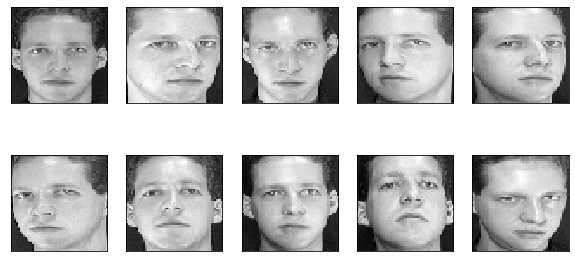

In [0]:
def display_batch_imgs_att(img_height, img_width, imgs_dir):
    """
    Visualize batches of images from at&t dataset
    """
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    for index, photofile in enumerate(natsorted(os.listdir(imgs_dir))):
        sp = plt.subplot(2, 5, index+1)
        sp.set_xticks([])
        sp.set_yticks([])
        img_path = os.path.join(imgs_dir, photofile)
        img = load_img(path=img_path,
                       target_size=(img_height, img_width),
                       color_mode='grayscale',
                       interpolation='nearest')
        imgplot = plt.imshow(img, cmap='gray')
    fig.show()     

subject = 's1'
display_batch_imgs_att(img_height, img_width,
                       imgs_dir=os.path.join(att_dir, subject))

In [0]:
def clear_att(dataset_dir):
    for item in os.scandir(dataset_dir):
        if not item.is_dir():
            os.unlink(item.path)
    
clear_att(att_dir)

In [0]:
att_pipeline = Dataset(img_height, img_width, face_detector)
att_pipeline.iterate(dataset_dir=att_dir)
att_pairs, att_labels = att_pipeline.create_pairs(get_info=False)

Loading images from /content/datasets/att/s1...
Loading images from /content/datasets/att/s2...
Loading images from /content/datasets/att/s3...
Loading images from /content/datasets/att/s4...
Loading images from /content/datasets/att/s5...
Loading images from /content/datasets/att/s6...
Loading images from /content/datasets/att/s7...
Loading images from /content/datasets/att/s8...
Loading images from /content/datasets/att/s9...
Loading images from /content/datasets/att/s10...
Loading images from /content/datasets/att/s11...
Loading images from /content/datasets/att/s12...
Loading images from /content/datasets/att/s13...
Loading images from /content/datasets/att/s14...
Loading images from /content/datasets/att/s15...
Loading images from /content/datasets/att/s16...
Loading images from /content/datasets/att/s17...
Loading images from /content/datasets/att/s18...
Loading images from /content/datasets/att/s19...
Loading images from /content/datasets/att/s20...
Loading images from /content/

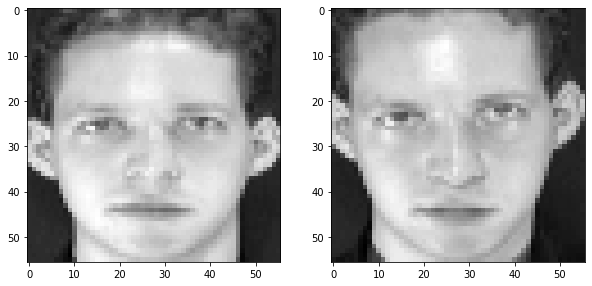

In [0]:
'''
Visualizing one pair of images, from the at&t dataset 
x_input[0] is one pair that has two images: x_input[0][0] and x_input[0][1]
x_input[1] is another pair the has two images: x_input[1][0] and x_input[1][1]
'''
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(array_to_img(att_pairs[2][0]), cmap='gray')
ax[1].imshow(array_to_img(att_pairs[2][1]), cmap='gray')
fig.show()

In [0]:
def move_essex94_files(dataset_dir, e):
    shutil.rmtree(dataset_dir)
    dataset_dir = e.extract_essex94(flag_display_info=False)
    essex94_clean_dir = os.path.join(dataset_dir, 'essex94_clean')
    try:
        os.mkdir(essex94_clean_dir)
    except FileExistsError as error:
        pass
    for folder in natsorted(os.listdir(dataset_dir)):
        folder_dir = os.path.join(dataset_dir, folder)
        for subfolder in natsorted(os.listdir(folder_dir)):
            subfolder_dir = os.path.join(folder_dir, subfolder)
            shutil.move(src=subfolder_dir, dst=essex94_clean_dir)
    for folder in os.listdir(dataset_dir):
        if folder != 'essex94_clean':
            folder_dir = os.path.join(dataset_dir, folder)
            shutil.rmtree(folder_dir)
    return essex94_clean_dir

def remove_not_enought_faces_essex(dataset_dir, dataset, face_detector, e):
    shutil.rmtree(dataset_dir)
    if dataset == 'essex94':
        dataset_dir = move_essex94_files(essex94_dir, e)
    elif dataset == 'essex95':
        dataset_dir = e.extract_essex95()
    elif dataset == 'essex96':
        dataset_dir = e.extract_essex96()
    elif dataset == 'essex grimace':
        dataset_dir = e.extract_essexgrimace()
    else:
        print('Invalid dataset name')
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        for photofile in natsorted(os.listdir(subject_dir)):
            if photofile.endswith('jpg'):
                photofile_path = os.path.join(subject_dir, photofile)
                img = cv2.imread(photofile_path)
                gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
                face_coord = face_detector.detectMultiScale(gray,
                                                            scaleFactor=1.2,
                                                            minNeighbors=5)
                if not isinstance(face_coord, np.ndarray):
                    shutil.rmtree(subject_dir)
                    print(f'Did not recognized a face for the images in '
                          f'"{subject_dir}". Subject removed')
                    break

def remove_different_number_of_imgs_essex(dataset_dir):
    nimgs_per_subject = 0
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        for img in natsorted(os.listdir(subject_dir)):
            if img.endswith('jpg'):
                nimgs_per_subject += 1
        if nimgs_per_subject != 20:        
            shutil.rmtree(subject_dir)
            print(f'Remove {subject_dir}. It had {nimgs_per_subject} images')
        nimgs_per_subject = 0  
        
def remove_no_imgs_essex(dataset_dir):
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        for imgfile in os.scandir(subject_dir):
            if imgfile.is_dir():
                directory = os.path.join(subject_dir, imgfile.name)
                shutil.rmtree(directory)
                print(f'Removed {directory}')
            elif not imgfile.path.endswith('.jpg'):
                os.unlink(imgfile.path)
                print(f'Removed {imgfile.path}')

essex94_clean_dir = move_essex94_files(essex94_dir, extractor)
remove_not_enought_faces_essex(dataset_dir=essex94_clean_dir, 
                               dataset='essex94', 
                               face_detector=face_detector, e=extractor)

remove_not_enought_faces_essex(dataset_dir=essex95_dir,
                               dataset='essex95',
                               face_detector=face_detector, e=extractor)
remove_not_enought_faces_essex(dataset_dir=essex96_dir,
                               dataset='essex96',
                               face_detector=face_detector, e=extractor)
remove_not_enought_faces_essex(dataset_dir=essexgrimace_dir,
                               dataset='essex grimace',
                               face_detector=face_detector, e=extractor)
remove_different_number_of_imgs_essex(essex94_clean_dir)
remove_different_number_of_imgs_essex(essex95_dir)
remove_different_number_of_imgs_essex(essex96_dir)
remove_different_number_of_imgs_essex(essexgrimace_dir)
remove_no_imgs_essex(essex94_clean_dir)
remove_no_imgs_essex(essex95_dir)
remove_no_imgs_essex(essex96_dir)
remove_no_imgs_essex(essexgrimace_dir)


Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/9338543". Subject removed
Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/djmart". Subject removed
Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/doraj". Subject removed
Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/gotone". Subject removed
Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/gpsmit". Subject removed
Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/ksunth". Subject removed
Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/martin". Subject removed
Did not recognized a face for the images in "/content/datasets/essex94/faces94/essex94_clean/mpetti". Subject removed
Did not recognized a face for the images in "/content/da

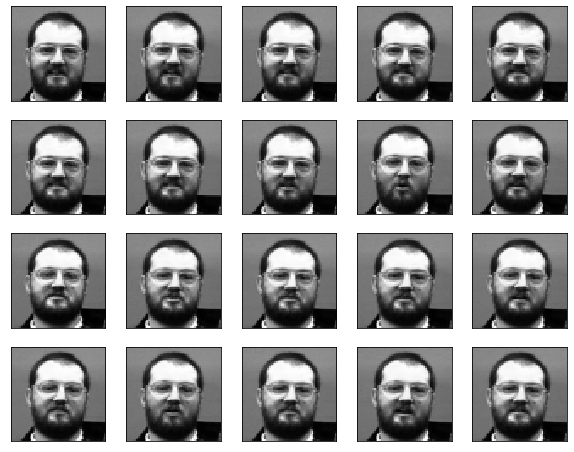

In [0]:
def display_imgs_essex(dataset_dir, subject):
    subject_dir = os.path.join(dataset_dir, subject)
    nrows, ncols = 4, len(os.listdir(subject_dir))//4
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    rows = list(range(nrows))
    rows = [row for row in rows for _ in range(ncols)]
    cols = nrows*list(range(ncols))
    imgs_path = [os.path.join(subject_dir, imgpath)
                 for imgpath in natsorted(os.listdir(subject_dir))]
    for row, col, imgpath in zip(rows, cols, imgs_path):
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        img = load_img(path=imgpath,
                       target_size=(56, 56),
                       color_mode='grayscale',
                       interpolation='hamming')
        ax[row, col].imshow(img, cmap='gray')
    fig.show()    
    
display_imgs_essex(essex94_clean_dir, subject='9326871')

In [0]:
essex94_pipeline = Dataset(img_height, img_width, face_detector)
essex94_pipeline.iterate(dataset_dir=essex94_clean_dir,
                         apply_face_det=True,
                         apply_gamma_correction=False)
essex94_pairs, essex94_labels = essex94_pipeline.create_pairs(get_info=False)
essex95_pipeline = Dataset(img_height, img_width, face_detector)
essex95_pipeline.iterate(dataset_dir=essex95_dir,
                         apply_face_det=True,
                         apply_gamma_correction=False)
essex95_pairs, essex95_labels = essex95_pipeline.create_pairs(get_info=False)
essex96_pipeline = Dataset(img_height, img_width, face_detector)
essex96_pipeline.iterate(dataset_dir=essex96_dir,
                         apply_face_det=True,
                         apply_gamma_correction=False)
essex96_pairs, essex96_labels = essex96_pipeline.create_pairs(get_info=False)
essexgrimace_pipeline = Dataset(img_height, img_width, face_detector)
essexgrimace_pipeline.iterate(dataset_dir=essexgrimace_dir,
                         apply_face_det=True,
                         apply_gamma_correction=False)
essexgrimace_pairs, essexgrimace_labels = essexgrimace_pipeline.create_pairs(get_info=False)

Loading images from /content/datasets/essex94/faces94/essex94_clean/9326871...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9332898...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9336923...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338446...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338454...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338462...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338489...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338497...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338519...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338527...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9338535...
Loading images from /content/datasets/essex94/faces94/essex94_clean/9414649...
Loading images from /content/datasets/essex94/faces9

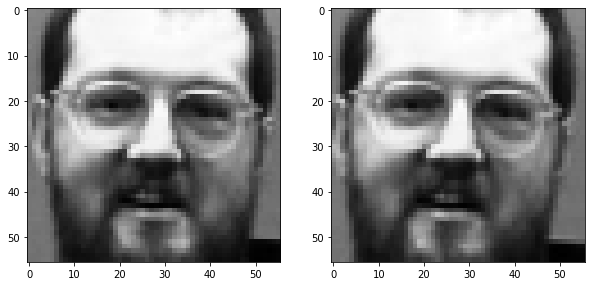

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(array_to_img(essex94_pairs[0][0]), cmap='gray')
ax[1].imshow(array_to_img(essex94_pairs[0][1]), cmap='gray')

In [0]:
def move_muct_imgfiles(muct_dir):
    try:
        os.mkdir('/content/datasets/muct/muct_clean')
    except FileExistsError as error:
        pass
    try:
        for index in range(625):
            new_dir = os.path.join('/content/datasets/muct/muct_clean', 
                                   f'subject{index}')
            os.mkdir(new_dir)            
    except FileExistsError as error:
        pass
    for muct_position in natsorted(os.listdir(muct_dir)):
        muct_pos_path = os.path.join(muct_dir, muct_position)
        for imgfile in natsorted(os.listdir(muct_pos_path)):
            imgfile_path = os.path.join(muct_pos_path, imgfile)
            for index in range(625):
                if imgfile.startswith(f'i{index:03d}'):
                    shutil.move(src=imgfile_path, 
                                dst='/content/datasets/muct/muct_clean/'
                                    f'subject{index}')
    for folder in natsorted(os.listdir('/content/datasets/muct/muct_clean')):
        folder_dir = os.path.join('/content/datasets/muct/muct_clean', folder)
        if os.listdir(folder_dir) == []:
            shutil.rmtree(folder_dir)
            print(f'Removed {folder_dir}. Did\'t have any images')
    return os.path.join(muct_dir, 'muct_clean')

def remove_no_faces_muct(muct_dir):
    nsubjetcs_before = len(os.listdir(muct_dir))
    for subject in natsorted(os.listdir(muct_dir)):
        subject_dir = os.path.join(muct_dir, subject)
        for imgfile in natsorted(os.listdir(subject_dir)):
            imgfile_path = os.path.join(subject_dir, imgfile)
            img = cv2.imread(imgfile_path)
            gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
            face_coord = face_detector.detectMultiScale(gray,
                                                        scaleFactor=1.2,
                                                        minNeighbors=5)
            if not isinstance(face_coord, np.ndarray):
                shutil.rmtree(subject_dir)
                print(f'Removed {subject_dir}')
                break
    nsubjects_after = len(os.listdir(muct_dir))
    print(f'Go from {nsubjetcs_before} to {nsubjects_after} after this segment')

def remove_more_then_10_faces_muct(dataset_dir):
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        for index, imgfile in enumerate(natsorted(os.listdir(subject_dir)),
                                        start=1):
            imgpath = os.path.join(subject_dir, imgfile)
            if index > 10:
                os.unlink(imgpath)
                print(f'Removed {imgpath}. It was part of a subject that had '
                      f'more then 10 images')    
    
muct_clean_dir = move_muct_imgfiles(muct_dir)  
remove_no_faces_muct(muct_clean_dir)  
remove_more_then_10_faces_muct(muct_clean_dir)

In [0]:
muct_pipeline = Dataset(img_height, img_width, face_detector)
muct_pipeline.iterate(dataset_dir=muct_clean_dir,
                      apply_face_det=True,
                      apply_gamma_correction=False)
muct_pairs, muct_labels = muct_pipeline.create_pairs(get_info=False)

Loading images from /content/datasets/muct/muct_clean/subject0...
Loading images from /content/datasets/muct/muct_clean/subject1...
Loading images from /content/datasets/muct/muct_clean/subject2...
Loading images from /content/datasets/muct/muct_clean/subject3...
Loading images from /content/datasets/muct/muct_clean/subject4...
Loading images from /content/datasets/muct/muct_clean/subject6...
Loading images from /content/datasets/muct/muct_clean/subject7...
Loading images from /content/datasets/muct/muct_clean/subject8...
Loading images from /content/datasets/muct/muct_clean/subject9...
Loading images from /content/datasets/muct/muct_clean/subject10...
Loading images from /content/datasets/muct/muct_clean/subject11...
Loading images from /content/datasets/muct/muct_clean/subject12...
Loading images from /content/datasets/muct/muct_clean/subject13...
Loading images from /content/datasets/muct/muct_clean/subject14...
Loading images from /content/datasets/muct/muct_clean/subject15...
Load

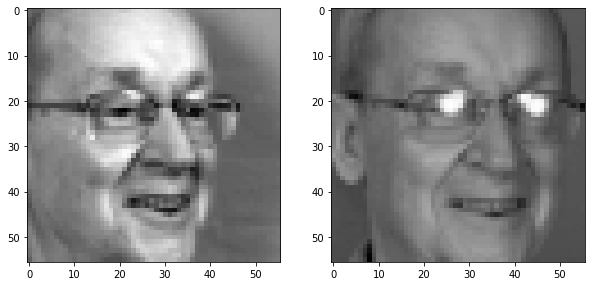

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(array_to_img(muct_pairs[4000][0]), cmap='gray')
ax[1].imshow(array_to_img(muct_labels[4000][1]), cmap='gray')

In [0]:
def move_carnegie_imgs(carnegie_dir):
    carnegie_clean_dir = os.path.join(carnegie_dir, 'carnegie_clean')
    try:
        os.mkdir(carnegie_clean_dir)
    except FileExistsError as error:
        pass
    try:
        for index in range(1, 91):
            new_dir = os.path.join(carnegie_clean_dir, f'subject{index:02d}')
            os.mkdir(new_dir)
    except FileExistsError as error:
        pass
    for imgfile in natsorted(os.listdir(carnegie_dir)):
        if imgfile.endswith('.Jpg') or imgfile.endswith('.jpg'):
            imgfile_path = os.path.join(carnegie_dir, imgfile)
            for index in range(0, 91):
                if imgfile.startswith(f'{index:02d}', 2):
                    shutil.move(src=imgfile_path, 
                                dst=f'/content/datasets/carnegie/carnegie_clean'
                                    f'/subject{index:02d}')
    for imgfile in natsorted(os.listdir(carnegie_dir)):
        if imgfile.endswith('.Jpg') or imgfile.endswith('.jpg'):
            imgfile_path = os.path.join(carnegie_dir, imgfile)
            os.unlink(imgfile_path)    
    return carnegie_clean_dir

def normalize_30imgs_carnegie(dataset_dir, imgheight, imgwidth, face_detector):
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        count_faces = 0
        for imgfile in natsorted(os.listdir(subject_dir)):
            imgpath = os.path.join(subject_dir, imgfile)
            img = cv2.imread(imgpath)
            gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
            face_coord = face_detector.detectMultiScale(gray, 
                                                        scaleFactor=1.2,
                                                        minNeighbors=5)
            if isinstance(face_coord, np.ndarray):
                count_faces += 1
                x_start, y_start, width, height = face_coord[0]
                cv2.imwrite(filename='/content/face.jpg',
                            img=gray[y_start:y_start+height,
                                     x_start:x_start+width])
                img = load_img(path='/content/face.jpg',
                               target_size=(img_height, img_width),
                               color_mode='grayscale',
                               interpolation='nearest')
                os.unlink('/content/face.jpg')
                if count_faces > 30:
                    os.unlink(imgpath)
            else:
                os.unlink(imgpath)
        if count_faces < 30:
            shutil.rmtree(subject_dir)
            print(f'Removed {subject_dir}. Only recognize {count_faces} faces')
                                
carnegie_clean_dir = move_carnegie_imgs(carnegie_dir)
normalize_30imgs_carnegie(carnegie_clean_dir, img_height, img_width, 
                          face_detector)

Removed /content/datasets/carnegie/carnegie_clean/subject33. Only recognize 22 faces
Removed /content/datasets/carnegie/carnegie_clean/subject53. Only recognize 29 faces
Removed /content/datasets/carnegie/carnegie_clean/subject65. Only recognize 29 faces
Removed /content/datasets/carnegie/carnegie_clean/subject74. Only recognize 28 faces
Removed /content/datasets/carnegie/carnegie_clean/subject78. Only recognize 29 faces


In [0]:
carnegie_pipeline = Dataset(img_height, img_width, face_detector)
carnegie_pipeline.iterate(dataset_dir=carnegie_clean_dir,
                      apply_face_det=True,
                      apply_gamma_correction=False)
carnegie_pairs, carnegie_labels = carnegie_pipeline.create_pairs(get_info=False)

Loading images from /content/datasets/carnegie/carnegie_clean/subject01...
Loading images from /content/datasets/carnegie/carnegie_clean/subject02...
Loading images from /content/datasets/carnegie/carnegie_clean/subject03...
Loading images from /content/datasets/carnegie/carnegie_clean/subject04...
Loading images from /content/datasets/carnegie/carnegie_clean/subject05...
Loading images from /content/datasets/carnegie/carnegie_clean/subject06...
Loading images from /content/datasets/carnegie/carnegie_clean/subject07...
Loading images from /content/datasets/carnegie/carnegie_clean/subject08...
Loading images from /content/datasets/carnegie/carnegie_clean/subject09...
Loading images from /content/datasets/carnegie/carnegie_clean/subject10...
Loading images from /content/datasets/carnegie/carnegie_clean/subject11...
Loading images from /content/datasets/carnegie/carnegie_clean/subject12...
Loading images from /content/datasets/carnegie/carnegie_clean/subject13...
Loading images from /cont

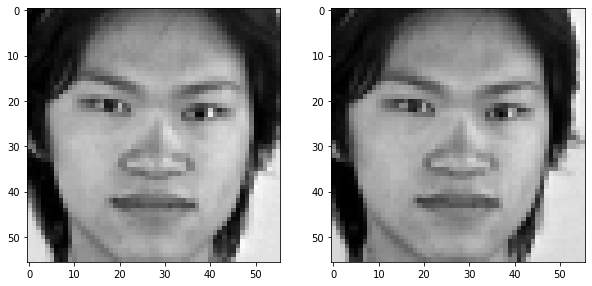

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(array_to_img(carnegie_pairs[0][0]), cmap='gray')
ax[1].imshow(array_to_img(carnegie_labels[0][1]), cmap='gray')

In [0]:
def clear_yale(dataset_dir):
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        for imgfile in natsorted(os.listdir(subject_dir)):
            imgfile_path = os.path.join(subject_dir, imgfile)
            if not imgfile.endswith('.pgm') or imgfile.endswith('Ambient.pgm'):
                os.unlink(imgfile_path)           

def normalize_58imgs_yale(dataset_dir):
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        for index, imgfile in enumerate(natsorted(os.listdir(subject_dir)),
                                        start=1):
            imgpath = os.path.join(subject_dir, imgfile)
            if index > 58:
                try:
                    os.unlink(imgpath)
                except FileNotFoundError as error:
                    pass            

clear_yale(yale_dir)
normalize_58imgs_yale(yale_dir)      

58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 

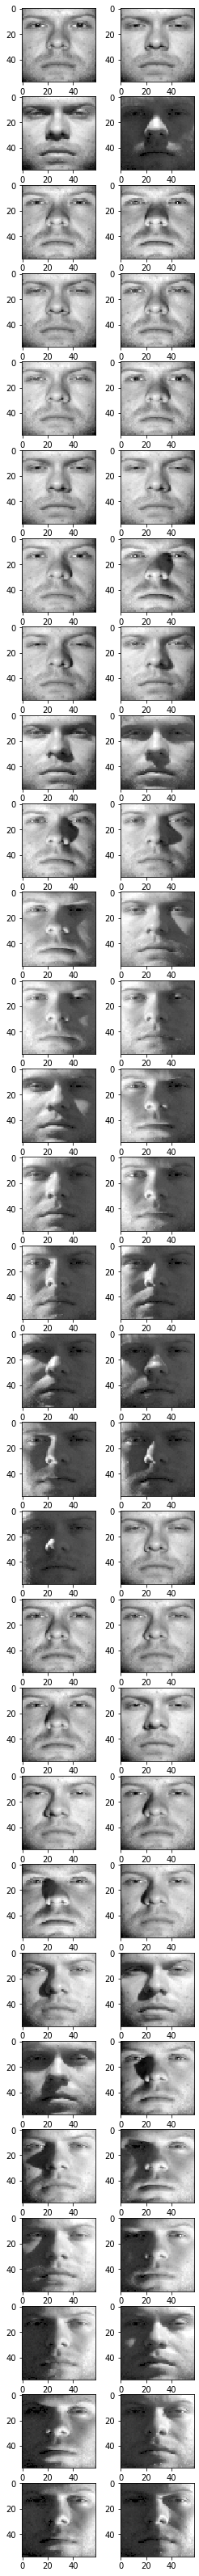

In [0]:
def adjust_gamma(imgpath, gamma):
    img = cv2.imread(imgpath)
    inv_gamma = 1/gamma
    table = np.array([((i / 255) ** inv_gamma) * 255
                     for i in np.arange(0, 256)]).astype('uint8')
    new_img = cv2.LUT(img, table)
    new_img_path = '/content/tmp/img.jpg'
    cv2.imwrite(filename=new_img_path,
                img=new_img)
    return new_img_path     

def display_yale_imgs(base_dir, subject, nrows, ncols, ftype):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(ncols*2, nrows*2))
    rows = list(range(nrows))
    rows = [row for row in rows for _ in range(ncols)]
    cols = nrows*list(range(ncols))
    imgs_dir = os.path.join(base_dir, subject)
    imgs_path = [os.path.join(imgs_dir, img_path) 
                 for img_path in natsorted(os.listdir(imgs_dir))]
    for row, col, imgpath in zip(rows, cols, imgs_path):
        new_imgpath = adjust_gamma(imgpath, gamma=2.5)
        img = load_img(path=new_imgpath,
                       target_size=(58, 58),
                       color_mode='grayscale',
                       interpolation='nearest')
        ax[row, col].imshow(img, cmap='gray')
        os.unlink(new_imgpath)
    fig.show()         

display_yale_imgs(base_dir=yale_dir, subject='yaleB01', nrows=29, ncols=2,
                  ftype='.pgm')

for subject in natsorted(os.listdir('/content/datasets/yale/CroppedYale')):
    subject_dir = os.path.join('/content/datasets/yale/CroppedYale', subject)
    print(len(os.listdir(subject_dir)), end=', ') 

In [0]:
yale_pipeline = Dataset(img_height, img_width, face_detector)
yale_pipeline.iterate(dataset_dir=yale_dir, 
                      apply_face_det=False, 
                      apply_gamma_correction=True)
yale_pairs, yale_labels = yale_pipeline.create_pairs(get_info=False)

Loading images from /content/datasets/yale/CroppedYale/yaleB01...
Loading images from /content/datasets/yale/CroppedYale/yaleB02...
Loading images from /content/datasets/yale/CroppedYale/yaleB03...
Loading images from /content/datasets/yale/CroppedYale/yaleB04...
Loading images from /content/datasets/yale/CroppedYale/yaleB05...
Loading images from /content/datasets/yale/CroppedYale/yaleB06...
Loading images from /content/datasets/yale/CroppedYale/yaleB07...
Loading images from /content/datasets/yale/CroppedYale/yaleB08...
Loading images from /content/datasets/yale/CroppedYale/yaleB09...
Loading images from /content/datasets/yale/CroppedYale/yaleB10...
Loading images from /content/datasets/yale/CroppedYale/yaleB11...
Loading images from /content/datasets/yale/CroppedYale/yaleB12...
Loading images from /content/datasets/yale/CroppedYale/yaleB13...
Loading images from /content/datasets/yale/CroppedYale/yaleB15...
Loading images from /content/datasets/yale/CroppedYale/yaleB16...
Loading im

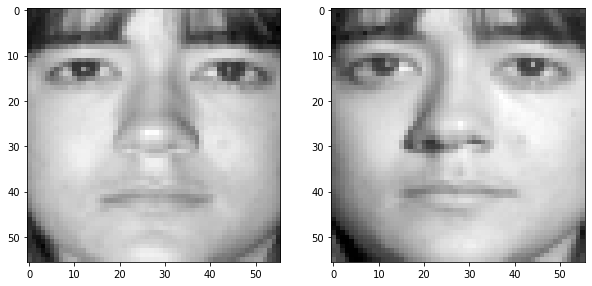

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(array_to_img(yale_pipeline.pairs[100000][0]), cmap='gray')
ax[1].imshow(array_to_img(yale_pipeline.pairs[100000][1]), cmap='gray')

In [0]:
def clear_caltech_files(dataset_dir):
    try:
        for file in natsorted(os.listdir(dataset_dir)):
            file_path = os.path.join(dataset_dir, file)
            if not file.endswith('.jpg'):
                os.unlink(file_path)
    except FileNotFoundError as error:
        pass
    
def move_caltech_files_aux(base_dir, imgfile, imgpath, n):
    new_dst_dir = os.path.join(base_dir, f'subject{n}')
    try:
        os.mkdir(new_dst_dir)
    except FileExistsError as error:
        pass
    new_dst_dir = os.path.join(new_dst_dir, imgfile)
    try:
        shutil.move(src=imgpath, dst=new_dst_dir)
    except FileNotFoundError as error:
        pass

def move_caltech_files(dataset_dir):
    for index, imgfile in enumerate(natsorted(os.listdir(dataset_dir)), 
                                    start=1):
        imgpath = os.path.join(dataset_dir, imgfile)
        base_dir = '/content/datasets/caltech'
        if index <= 18:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=1)
        elif index >= 23 and index <= 23+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=2)
        elif index >= 47 and index <= 47+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=3)
        elif index >= 69 and index <= 69+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=4)
        elif index >= 90 and index <= 90+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=5)
        elif index >= 113 and index <= 113+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=6)
        elif index >= 133 and index <= 133+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=7)
        elif index >= 176 and index <= 176+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=8)
        elif index >= 196 and index <= 196+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=9)
        elif index >= 217 and index <= 217+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=10)
        elif index >= 242 and index <= 242+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=11)
        elif index >= 269 and index <= 269+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=12)
        elif index >= 288 and index <= 288+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=13)
        elif index >= 308 and index <= 308+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=14)
        elif index >= 337 and index <= 337+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=15)
        elif index >= 357 and index <= 357+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=16)
        elif index >= 377 and index <= 377+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=17)
        elif index >= 429 and index <= 429+18-1:
            move_caltech_files_aux(base_dir, imgfile, imgpath, n=18)   

def remove_caltech_not_enought_files(dataset_dir):
    for item in os.scandir(dataset_dir):
        if not item.is_dir():
            os.unlink(item.path)
            
def remove_caltech_not_enought_faces(dataset_dir):
    for subject in natsorted(os.listdir(dataset_dir)):
        subject_dir = os.path.join(dataset_dir, subject)
        for imgfile in natsorted(os.listdir(subject_dir)):
            imgpath = os.path.join(subject_dir, imgfile)
            img = cv2.imread(imgpath)
            gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
            face_coord = face_detector.detectMultiScale(gray,
                                                        scaleFactor=1.2,
                                                        minNeighbors=5)
            if isinstance(face_coord, tuple):
                shutil.rmtree(subject_dir)
                print(f'Removed "{subject_dir}". It had problems recognizing '
                      f'face for file "{imgpath}"')
                break
                
clear_caltech_files(caltech_dir)
move_caltech_files(caltech_dir)      
remove_caltech_not_enought_files(caltech_dir)
remove_caltech_not_enought_faces(caltech_dir)

Removed "/content/datasets/caltech/subject7". It had problems recognizing face for file "/content/datasets/caltech/subject7/image_0135.jpg"
Removed "/content/datasets/caltech/subject13". It had problems recognizing face for file "/content/datasets/caltech/subject13/image_0298.jpg"
Removed "/content/datasets/caltech/subject14". It had problems recognizing face for file "/content/datasets/caltech/subject14/image_0321.jpg"


In [0]:
caltech_pipeline = Dataset(img_height, img_width, face_detector)
caltech_pipeline.iterate(dataset_dir=caltech_dir, 
                         apply_face_det=True, 
                         apply_gamma_correction=False)
caltech_pairs, caltech_labels = caltech_pipeline.create_pairs(get_info=False)

Loading images from /content/datasets/caltech/subject1...
Loading images from /content/datasets/caltech/subject2...
Loading images from /content/datasets/caltech/subject3...
Loading images from /content/datasets/caltech/subject4...
Loading images from /content/datasets/caltech/subject5...
Loading images from /content/datasets/caltech/subject6...
Loading images from /content/datasets/caltech/subject8...
Loading images from /content/datasets/caltech/subject9...
Loading images from /content/datasets/caltech/subject10...
Loading images from /content/datasets/caltech/subject11...
Loading images from /content/datasets/caltech/subject12...
Loading images from /content/datasets/caltech/subject15...
Loading images from /content/datasets/caltech/subject16...
Loading images from /content/datasets/caltech/subject17...
Loading images from /content/datasets/caltech/subject18...
For /content/datasets/caltech
Number of subjects = 15
Number of images per subject = 18
Total number of images = 270

Creat

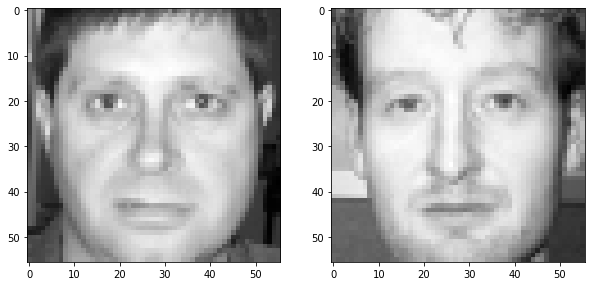

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(array_to_img(caltech_pipeline.pairs[253][0]), cmap='gray')
ax[1].imshow(array_to_img(caltech_pipeline.pairs[253][1]), cmap='gray')

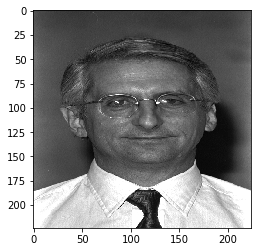

In [0]:
imgpath = ('/content/gdrive/My Drive/datasets /'
           'facial recognition/feret/feret_images/'
           '00001/00001_930831_fb_a.ppm.bz2')

with bz2.open(imgpath, 'rb') as bz2file, open('/content/tmp/img.ppm', 'wb') as ppmfile:
    shutil.copyfileobj(bz2file, ppmfile)
    
img = load_img(path='/content/tmp/img.ppm',
               target_size=(224, 224),
               color_mode='grayscale',
               interpolation='nearest')
plt.imshow(img, cmap='gray')    

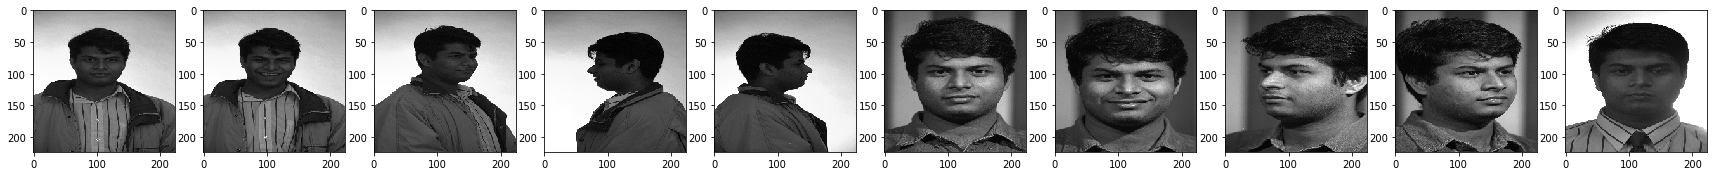

In [0]:
def display_feret_imgs(dataset_dir, subject):
    fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(30, 30))
    subject_dir = os.path.join(dataset_dir, subject)
    imgs_path = [os.path.join(subject_dir, img_path) 
                 for img_path in os.listdir(subject_dir)]
    for index, compressed_file in enumerate(natsorted(imgs_path[:10])):
        compressed_file_path = os.path.join(subject_dir, compressed_file)
        with bz2.open(compressed_file_path, 'rb') as bz2file, \
             open('/content/tmp/img.ppm', 'wb') as ppmfile:
            shutil.copyfileobj(bz2file, ppmfile)          
        img = load_img(path='/content/tmp/img.ppm',
                       target_size=(224, 224),
                       color_mode='grayscale',
                       interpolation='nearest')
        ax[index].imshow(img, cmap='gray')

feret_dir = ('/content/gdrive/My Drive/datasets /facial recognition/'
             'feret/feret_images')
display_feret_imgs(feret_dir, subject='00070')

In [0]:
def feret_decompress_4faces(dataset_dir):
    """
    When minNeighbors is bellow 16, there is a problem with some 
    subjects, e.g. the viola-jones algorithm recognizes some 
    artifacts as faces.
    """
    count_faces = 0
    base_dir = '/content/datasets/feret'
    try:
        os.mkdir(base_dir)
    except FileExistsError as error:
        pass
    for index, subject in enumerate(natsorted(os.listdir(dataset_dir)), 
                                    start=1):
        new_dst_dir = os.path.join(base_dir, f'subject{index}')
        subject_dir = os.path.join(dataset_dir, subject)
        print(f'Preprocessing "{subject_dir}"', end='. ')
        t = time.time()
        print(f'Time =', end=' ')
        try:
            os.mkdir(new_dst_dir)
        except FileExistsError as error:
            pass
        for index, compressed_file in enumerate(natsorted(os.listdir(subject_dir)),
                                                start=1):
            compressed_file_path = os.path.join(subject_dir, compressed_file)
            with bz2.open(compressed_file_path, 'rb') as bz2file, \
                     open('/content/tmp/img.ppm', 'wb') as ppmfile:
                shutil.copyfileobj(bz2file, ppmfile)
            img = cv2.imread('/content/tmp/img.ppm')
            gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
            face_coord = face_detector.detectMultiScale(gray,
                                                        scaleFactor=1.2,
                                                        minNeighbors=16)
            if isinstance(face_coord, np.ndarray):
                count_faces += 1
                x_start, y_start, width, height = face_coord[0]
                cv2.imwrite(filename=os.path.join(new_dst_dir, 
                                                  f'img{index}.ppm'), 
                            img=img[y_start:y_start+height,
                                    x_start:x_start+width])
            if count_faces == 4:
                break
        if count_faces < 4:
            shutil.rmtree(new_dst_dir)
        count_faces = 0
        display_time(t)

feret_decompress_4faces(feret_dir)

Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00001". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00002". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00003". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00004". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00005". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00006". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00007". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00008". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/feret/feret_images/00009". Time = Preprocessing "/content/gdrive/My Drive/datasets /facial recognition/fere

In [0]:
feret_pipeline = Dataset(img_height, img_width, face_detector)
feret_pipeline.iterate(dataset_dir='/content/datasets/feret', 
                       apply_face_det=False,
                       apply_gamma_correction=False)
feret_pairs, feret_labels = feret_pipeline.create_pairs(get_info=False)

Loading images from /content/datasets/feret/subject2...
Loading images from /content/datasets/feret/subject3...
Loading images from /content/datasets/feret/subject5...
Loading images from /content/datasets/feret/subject11...
Loading images from /content/datasets/feret/subject12...
Loading images from /content/datasets/feret/subject13...
Loading images from /content/datasets/feret/subject15...
Loading images from /content/datasets/feret/subject17...
Loading images from /content/datasets/feret/subject18...
Loading images from /content/datasets/feret/subject19...
Loading images from /content/datasets/feret/subject20...
Loading images from /content/datasets/feret/subject21...
Loading images from /content/datasets/feret/subject23...
Loading images from /content/datasets/feret/subject27...
Loading images from /content/datasets/feret/subject28...
Loading images from /content/datasets/feret/subject32...
Loading images from /content/datasets/feret/subject34...
Loading images from /content/datas

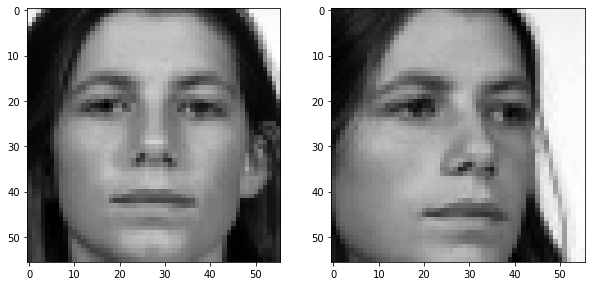

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(array_to_img(feret_pairs[2500][0]), cmap='gray')
ax[1].imshow(array_to_img(feret_labels[2500][1]), cmap='gray')

In [0]:
def create_imgs_list(dataset_dir, imgs_list):
    for root, dirs, files in natsorted(os.walk(dataset_dir)):
        if len(files) == 1:
            imgs_list.append(os.path.join(root, files[0]))
        elif len(files) > 1:
            for file in files:
                imgs_list.append(os.path.join(root, file))
    return imgs_list

def get_imgs_name(imgs_path):
    imgs_name = []
    for img_path in natsorted(imgs_path):
        topname = img_path[39:len(img_path)-9]
        name, _ = topname.split('/')
        imgs_name.append(name)        
    return imgs_name

def detect_face(imgpath, face_detector, idf):
    img = cv2.imread(imgpath)
    gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    face_coords = face_detector.detectMultiScale(gray,
                                                 scaleFactor=1.2,
                                                 minNeighbors=5)
    x_start, y_start, width, height = face_coords[0]
    if idf == 1:
        new_imgpath = '/content/tmp/face[1].jpg'
    else:
        new_imgpath = '/content/tmp/face[2].jpg'
    cv2.imwrite(filename=new_imgpath,
                img=gray[y_start:y_start+height,
                         x_start:x_start+width])
    return new_imgpath

def create_pairs_small(dataset_dir, face_detector):
    positive_pairs, negative_pairs = [], []
    base_img_index = 0
    imgs_path = create_imgs_list(dataset_dir, imgs_list=[])
    imgs_name = get_imgs_name(imgs_path)
    for index in range(len(imgs_name)):
        if index > base_img_index:
            if imgs_name[base_img_index] == imgs_name[index]:
                try:
                    imgpath1 = detect_face(imgs_path[base_img_index], face_detector, idf=1)
                    imgpath2 = detect_face(imgs_path[index], face_detector, idf=2)
                except IndexError as error:
                    print(f'error for {imgs_path[base_img_index]} and {imgs_path[index]}')
                    base_img_index += 1
                    continue
                img1 = load_img(path=imgpath1,
                                target_size=(img_width, img_height),
                                color_mode='grayscale',
                                interpolation='hamming')
                img2 = load_img(path=imgpath2,
                                target_size=(img_width, img_height),
                                color_mode='grayscale',
                                interpolation='hamming')
                img1 = img_to_array(img1).astype('float32') / 255
                img2 = img_to_array(img2).astype('float32') / 255               
                positive_pairs.append((img1, img2))
                print(f'Done for positive {imgs_name[base_img_index]} and {imgs_name[index]}')
            else:
                try:
                    imgpath1 = detect_face(imgs_path[base_img_index], face_detector, idf=1)
                    imgpath2 = detect_face(imgs_path[index], face_detector, idf=2)
                except IndexError as error:
                    print(f'error for {imgs_path[base_img_index]} and {imgs_path[index]}')
                    base_img_index += 1
                    continue
                img1 = load_img(path=imgpath1,
                                target_size=(img_width, img_height),
                                color_mode='grayscale',
                                interpolation='hamming')
                img2 = load_img(path=imgpath2,
                                target_size=(img_width, img_height),
                                color_mode='grayscale',
                                interpolation='hamming')
                img1 = img_to_array(img1).astype('float32') / 255
                img2 = img_to_array(img2).astype('float32') / 255
                negative_pairs.append((img1, img2))
                print(f'Done for negative {imgs_name[base_img_index]} and {imgs_name[index]}')
            base_img_index += 1    
    return positive_pairs, negative_pairs

positive_lfw_pairs, negative_lfw_pairs = create_pairs_small(lfw_dir, 
                                                            face_detector)

Done for negative AJ_Cook and AJ_Lamas
Done for negative AJ_Lamas and Aaron_Eckhart
Done for negative Aaron_Eckhart and Aaron_Guiel
Done for negative Aaron_Guiel and Aaron_Patterson
Done for negative Aaron_Patterson and Aaron_Peirsol
Done for positive Aaron_Peirsol and Aaron_Peirsol
Done for positive Aaron_Peirsol and Aaron_Peirsol
Done for positive Aaron_Peirsol and Aaron_Peirsol
Done for negative Aaron_Peirsol and Aaron_Pena
Done for negative Aaron_Pena and Aaron_Sorkin
Done for positive Aaron_Sorkin and Aaron_Sorkin
Done for negative Aaron_Sorkin and Aaron_Tippin
Done for negative Aaron_Tippin and Abba_Eban
Done for negative Abba_Eban and Abbas_Kiarostami
Done for negative Abbas_Kiarostami and Abdel_Aziz_Al-Hakim
Done for negative Abdel_Aziz_Al-Hakim and Abdel_Madi_Shabneh
Done for negative Abdel_Madi_Shabneh and Abdel_Nasser_Assidi
Done for positive Abdel_Nasser_Assidi and Abdel_Nasser_Assidi
Done for negative Abdel_Nasser_Assidi and Abdoulaye_Wade
Done for positive Abdoulaye_Wade 

In [0]:
lfw_pairs, lfw_labels = [], []
for pos, neg in zip(positive_lfw_pairs, negative_lfw_pairs):
    lfw_pairs.append(pos)
    lfw_labels.append(1)
    lfw_pairs.append(neg)
    lfw_labels.append(0)

In [0]:
print(len(lfw_pairs))
print(len(lfw_labels))

10812
10812


In [0]:
def save_h5file(**kwargs):
    fpath = ('/content/facial-recognition-6(all_but_essex_and_feret_and_lfw)-'
             'datasets-pairs.h5')
    with h5py.File(fpath, 'w') as f:
        for key in kwargs:
            f.create_dataset(key, data=kwargs[key])
    return fpath 

def save_gdrive(fpath):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    uploaded = drive.CreateFile({'title': fpath[9:]})
    uploaded.SetContentFile(fpath)
    uploaded.Upload()
    print('File uploaded in gdrive with id:', uploaded.get('id'))

In [0]:
"""
fpath = save_h5file(att_pairs=att_pipeline.pairs,
                    att_labels=att_pipeline.labels,
                    muct_pairs=muct_pipeline.pairs,
                    muct_labels=muct_pipeline.labels,
                    carnegie_pairs=carnegie_pipeline.pairs,
                    carnegie_labels=carnegie_pipeline.labels,
                    yale_pairs=yale_pipeline.pairs, 
                    yale_labels=yale_pipeline.labels,
                    caltech_pairs=caltech_pipeline.pairs,
                    caltech_labels=caltech_pipeline.labels,
                    feret_pairs=feret_pipeline.pairs,
                    feret_labels=feret_pipeline.labels)

save_gdrive(fpath)
"""

In [0]:
"""
def load_h5file():
    fpath = ('/content/facial-recognition-6(all_but_essex_and_feret_and_lfw)-'
             'datasets-pairs.h5')
    with h5py.File(path, 'r') as f:
        return (np.array(f.get('att_pairs')),
                np.array(f.get('att_labels')),
                np.array(f.get('muct_pairs')),
                np.array(f.get('muct_labels')),
                np.array(f.get('carnegie_pairs')),
                np.array(f.get('carnegie_labels')),
                np.array(f.get('yale_pairs')),
                np.array(f.get('yale_labels')),
                np.array(f.get('caltech_pairs')),
                np.array(f.get('caltech_labels')),
                np.array(f.get('feret_pairs')),
                np.array(f.get('feret_labels')))
    
(att_pairs, att_labels, muct_pairs, muct_labels, 
 carnegie_pairs, carnegie_labels, yale_pairs, yale_labels,
 caltech_pairs, caltech_labels, feret_pairs, feret_labels) = load_h5file()
 """

In [0]:
"""
This cell indicates how all the pairs would have been merged accessing 
the atributes of the Dataset class
"""
ds_pairs = (att_pipeline.pairs, carnegie_pipeline.pairs, 
            yale_pipeline.pairs, caltech_pipeline.pairs,
            feret_pipeline.pairs, essex94_pipeline.pairs, essex95_pipeline.pairs,
            essex96_pipeline.pairs, essexgrimace_pipeline.pairs, lfw_pairs)

ds_labels = (att_pipeline.labels, carnegie_pipeline.labels, 
             yale_pipeline.labels, caltech_pipeline.labels,
             feret_pipeline.labels, essex94_pipeline.labels, essex95_pipeline.labels,
             essex96_pipeline.labels, essexgrimace_pipeline.labels, lfw_labels)

input_pairs = [pair for ds_pair in ds_pairs for pair in ds_pair]
input_labels = [label for ds_label in ds_labels for label in ds_label]

In [0]:
"""
Since accessing attributes it's considered wrong in oop programming,
this cell indicates how all the pairs would have been merged catching 
the variables returned by the create_pairs method in the Dataset
"""
ds_pairs = (att_pairs, carnegie_pairs, 
            yale_pairs, caltech_pairs,
            feret_pairs, essex94_pairs, essex95_pairs,
            essex96_pairs, essexgrimace_pairs, lfw_pairs)

ds_labels = (att_labels, carnegie_labels, 
             yale_labels, caltech_labels,
             feret_labels, essex94_labels, essex95_labels,
             essex96_labels, essexgrimace_labels, lfw_labels)

input_pairs = [pair for ds_pair in ds_pairs for pair in ds_pair]
input_labels = [label for ds_label in ds_labels for label in ds_label]

In [0]:
input_pairs = np.array(input_pairs)
input_labels = np.array(input_labels)

In [0]:
test_pairs = np.array(muct_pipeline.pairs)
test_labels = np.array(muct_pipeline.labels)

In [0]:
print(len(input_pairs))
for div in range(1, 1000):
    print(f"{div} -> {len(input_pairs)/div}")

351348
1 -> 351348.0
2 -> 175674.0
3 -> 117116.0
4 -> 87837.0
5 -> 70269.6
6 -> 58558.0
7 -> 50192.57142857143
8 -> 43918.5
9 -> 39038.666666666664
10 -> 35134.8
11 -> 31940.727272727272
12 -> 29279.0
13 -> 27026.76923076923
14 -> 25096.285714285714
15 -> 23423.2
16 -> 21959.25
17 -> 20667.529411764706
18 -> 19519.333333333332
19 -> 18492.0
20 -> 17567.4
21 -> 16730.85714285714
22 -> 15970.363636363636
23 -> 15276.0
24 -> 14639.5
25 -> 14053.92
26 -> 13513.384615384615
27 -> 13012.888888888889
28 -> 12548.142857142857
29 -> 12115.448275862069
30 -> 11711.6
31 -> 11333.806451612903
32 -> 10979.625
33 -> 10646.90909090909
34 -> 10333.764705882353
35 -> 10038.514285714286
36 -> 9759.666666666666
37 -> 9495.891891891892
38 -> 9246.0
39 -> 9008.923076923076
40 -> 8783.7
41 -> 8569.463414634147
42 -> 8365.42857142857
43 -> 8170.883720930233
44 -> 7985.181818181818
45 -> 7807.733333333334
46 -> 7638.0
47 -> 7475.489361702128
48 -> 7319.75
49 -> 7170.367346938776
50 -> 7026.96
51 -> 6889.17647

In [0]:
def get_results_from_pairs(pairs, labels, trained_model, threshold):
    same_person_list, dif_persons_list = [], []
    nerrors_same_person, nerrors_dif_person = 0, 0
    for pair, label in zip(pairs, labels):
        if label == 1:
            img1 = pair[0]
            img1 = img1.reshape((1,) + img1.shape)
            img2 = pair[1]
            img2 = img2.reshape((1,) + img2.shape)
            nn_result = trained_model.predict([img1, img2])[0][0]
            print(f'Same person = {nn_result:.4f}', end=' ... ')
            same_person_list.append(nn_result)
            if nn_result >= threshold:
                nerrors_same_person += 1
        else:
            img1 = pair[0]
            img1 = img1.reshape((1,) + img1.shape)
            img2 = pair[1]
            img2 = img2.reshape((1,) + img2.shape)
            nn_result = trained_model.predict([img1, img2])[0][0]
            print(f'Different persons = {nn_result:.4f}')
            dif_persons_list.append(nn_result)
            if nn_result < threshold:
                nerrors_dif_person += 1
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    ax.plot(range(len(same_person_list)), 
            same_person_list,
            linestyle='solid',
            color='blue')
    ax.plot(range(len(dif_persons_list)),
            dif_persons_list,
            linestyle='solid',
            color='red')
    ax.grid(True)
    ax.legend(['same', 'different'])
    fig.show()
    print('Same people are meant to be a small valuee and different people are '
          'meant to be high values')
    print(f'Maximum same person = {max(same_person_list)}')
    print(f'Minimum diferent person = {min(dif_persons_list)}')
    print(f'Avg for same individuals = {sum(same_person_list)/len(same_person_list)}')
    print(f'Avg for different individuals = {sum(dif_persons_list)/len(dif_persons_list)}')
    print(f'\nNumber of errors for same person = {nerrors_same_person}')
    print(f'Number of errors for differnet persons = {nerrors_dif_person}')
    print(f'Total number of errors = {nerrors_same_person + nerrors_dif_person}, '
          f'on a total of {len(pairs)} imgs, '
          f'acc = {(len(pairs)-(nerrors_same_person+nerrors_dif_person))/len(pairs)}')
    
    
def plot_loss(history):
    height, width = 10, 10
    fig, ax = plt.subplots(figsize=(height, width))
    ax.plot(range(len(history.history['loss'])),
            history.history['loss'],
            linestyle='solid',
            color='red')
    ax.set_xlabel('Epochs', fontsize=20)
    ax.set_ylabel('Loss', fontsize=20)
    ax.grid(True)
    fig.show()
    
def visualize_results_in_batches(pairs, labels, model, start, end):
    fig, ax = plt.subplots(nrows=1, ncols=20, figsize=(30, 10))
    index = 0
    for pair, label in zip(pairs[start:end], labels[start:end]):
        if label == 1:
            img1 = pair[0]
            img1 = img1.reshape((1,) + img1.shape)
            img2 = pair[1]
            img2 = img2.reshape((1,) + img2.shape)
            nn_result = model.predict([img1, img2])[0][0]
            ax[index].imshow(array_to_img(pair[0]), cmap='gray')
            index += 1
            ax[index].imshow(array_to_img(pair[1]), cmap='gray')
            ax[index].set_title(f'{nn_result:.4f}')
        else:
            img1 = pair[0]
            img1 = img1.reshape((1,) + img1.shape)
            img2 = pair[1]
            img2 = img2.reshape((1,) + img2.shape)
            nn_result = model.predict([img1, img2])[0][0]
            index += 1
            ax[index].imshow(array_to_img(pair[0]), cmap='gray')
            index += 1
            ax[index].imshow(array_to_img(pair[1]), cmap='gray')
            ax[index].set_title(f'{nn_result:.4f}')
            index +=1

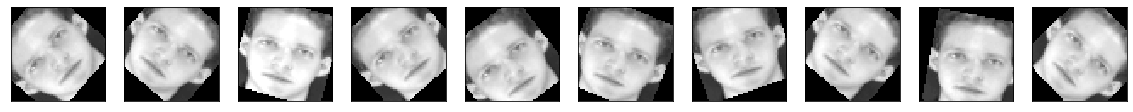

In [0]:
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=True,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=True,
                             zca_whitening=False,
                             zca_epsilon=1e-06,
                             rotation_range=50,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=(0.1, 1.2),
                             shear_range=0.2,
                             zoom_range=0,
                             channel_shift_range=0,
                             fill_mode='constant',
                             cval=0,
                             horizontal_flip=False,
                             vertical_flip=False,
                             rescale=None,
                             preprocessing_function=None,
                             data_format=None,
                             dtype=None)

array = att_pipeline.pairs[0][0]
array = array.reshape((1,) + array.shape)

i = 0
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20, 20))
for batch in datagen.flow(array, batch_size=1):
    data = batch[0]
    img = img_to_array(data)
    imgplot = ax[i].imshow(array_to_img(batch[0]), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i += 1
    if i % 10 == 0:
        fig.show()
        break

In [0]:
def generate_multiple(datagen, data, labels, batch_size):
    """This could have been used instead of 'datagen.flow'"""
    gen1 = datagen.flow(data[:, 0],
                        labels,
                        batch_size=batch_size,
                        shuffle=False)
    
    gen2 = datagen.flow(data[:, 1],
                        labels,
                        batch_size=batch_size,
                        shuffle=False)
    
    while True:
        x1 = gen1.next()
        x2 = gen2.next()
        yield [x1[0], x2[0]], x2[1]
    
batch_size_train = 3000
train_generator = generate_multiple(datagen_train, input_pairs, input_labels, 
                                    batch_size_train)
steps_per_epochs = int(len(input_pairs)/batch_size_train)


In [0]:
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

class ConvolutionalNeuralNetwork(Model):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = Conv2D(filters=32,
                            kernel_size=(3, 3),
                            padding='same',
                            activation='relu')
        self.conv2 = Conv2D(filters=32,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))
        self.conv3 = Conv2D(filters=64, 
                            kernel_size=(3, 3),
                            padding='same',
                            activation='relu')
        self.conv4 = Conv2D(filters=64,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))
        self.conv5 = Conv2D(filters=128,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.conv6 = Conv2D(filters=256,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2))
        self.conv7 = Conv2D(filters=512,
                            kernel_size=(3, 3),
                            padding="same", 
                            activation="relu")
        self.conv8 = Conv2D(filters=512, 
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.flatten = Flatten()
        self.dropout = Dropout(rate=0.5)
        self.dense1 = Dense(units=1024,
                            activation='relu')
        self.dense2 = Dense(units=1024,
                            activation='sigmoid')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x
    
class SiamesisNeuralNetwork:
    def __init__(self, datagen, input_shape, input_pairs, input_labels):
        self.datagen = datagen
        self.input_shape = input_shape
        self.input_pairs = input_pairs 
        self.input_labels = input_labels
        self.batch_size = 112
    
    def display_info(self):
        network = ConvolutionalNeuralNetwork()
        input_layer = Input(shape=(56, 56, 1))
        output_layer = network(input_layer)
        print('For each convolutional network:')
        print(network.summary())
    
    def create_inputs(self, input_shape):
        return Input(shape=input_shape), Input(shape=input_shape)
    
    def create_outputs(self, input_top, input_bottom, network):
        return network(input_top), network(input_bottom)
    
    def euclidian_distance(self, vectors):
        v, u = vectors
        print(type(vectors), type(v), type(u))
        return (K.maximum(K.sum(K.square(v-u), axis=1, keepdims=True),
                         K.epsilon()))
    
    def calculate_distance(self, output_top, output_bottom):
        return Lambda(function=self.euclidian_distance,
                      output_shape=(1,))([output_top, output_bottom])
    
    def create_premodel(self, input_top, input_bottom, distance):
        return Model(inputs=[input_top, input_bottom], outputs=distance)
    
    def contrastive_loss(self, y_true, D, margin=1):
        return K.mean(y_true*K.square(D)+(1-y_true)*K.maximum((margin-D), 0))
    
    def config_backpropagation(self, premodel):
        premodel.compile(loss=self.contrastive_loss,
                         optimizer='adadelta')
        return premodel
    
    def fit_data(self, model):
        history = model.fit_generator(self.datagen.flow([input_pairs[:,0], input_pairs[:,1]],
                                                   input_labels,
                                                   batch_size=self.batch_size),
                                      steps_per_epoch=len(self.input_pairs)/self.batch_size,
                                      epochs=18)
        return model, history
    
    def train(self):
        input_top, input_bottom = self.create_inputs(self.input_shape)
        network = ConvolutionalNeuralNetwork()
        output_top, output_bottom = self.create_outputs(input_top, 
                                                        input_bottom,
                                                        network)
        distance = self.calculate_distance(output_top, output_bottom)
        premodel = self.create_premodel(input_top, input_bottom, distance)  
        model = self.config_backpropagation(premodel)
        trained_model, history = self.fit_data(model)
        return trained_model, history

    
siams = SiamesisNeuralNetwork(datagen, input_shape, input_pairs, input_labels)
model, history = siams.train()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<class 'list'> <class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
Instructions for updating:
Use tf.cast instead.
Epoch 1/18
3138/3138 [==============================] - 286s 91ms/step - loss: 0.3098
Epoch 2/18
3138/3138 [==============================] - 276s 88ms/step - loss: 0.1464
Epoch 3/18
3138/3138 [==============================] - 286s 91ms/step - loss: 0.1071
Epoch 4/18
3138/3138 [==============================] - 283s 90ms/step - loss: 0.0878
Epoch 5/18
3138/3138 [==============================] - 283s 90ms/step - loss: 0.0745
Epoch 6/18
3138/3138 [==============================] - 283s 90ms/step - loss: 0.0653
Epoch 7/18
3138/3138 [==============================] - 283s 90ms/step - loss: 0.0580
Epoch 8/18
3138/3138 [============================

In [0]:
"""
12/11/2019
"""
fpath = "/content/weights_convlayers8_margin2_epochs18.h5"
model.save_weights(fpath)
save_gdrive(fpath)

File uploaded in gdrive with id: 1wZxnLfmgzVKXOwWV0EaHhwgA1IvMoPc6


Same person = 0.0188 ... Different persons = 0.2214
Same person = 0.1284 ... Different persons = 0.5779
Same person = 0.0598 ... Different persons = 1.6424
Same person = 0.0892 ... Different persons = 1.2126
Same person = 0.4791 ... Different persons = 1.8638
Same person = 0.1616 ... Different persons = 1.6877
Same person = 0.1826 ... Different persons = 1.3476
Same person = 1.4540 ... Different persons = 3.4664
Same person = 0.2140 ... Different persons = 1.4211
Same person = 0.0861 ... Different persons = 2.1074
Same person = 0.1048 ... Different persons = 1.2549
Same person = 0.0410 ... Different persons = 0.3312
Same person = 0.4654 ... Different persons = 1.1748
Same person = 0.1803 ... Different persons = 1.7217
Same person = 0.1324 ... Different persons = 1.3253
Same person = 1.4454 ... Different persons = 1.9570
Same person = 0.2290 ... Different persons = 1.3526
Same person = 0.1923 ... Different persons = 0.8822
Same person = 0.0860 ... Different persons = 2.2106
Same person 

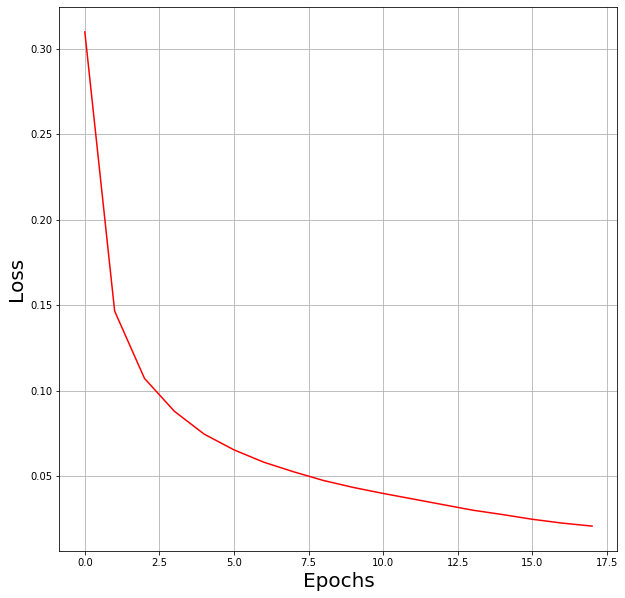

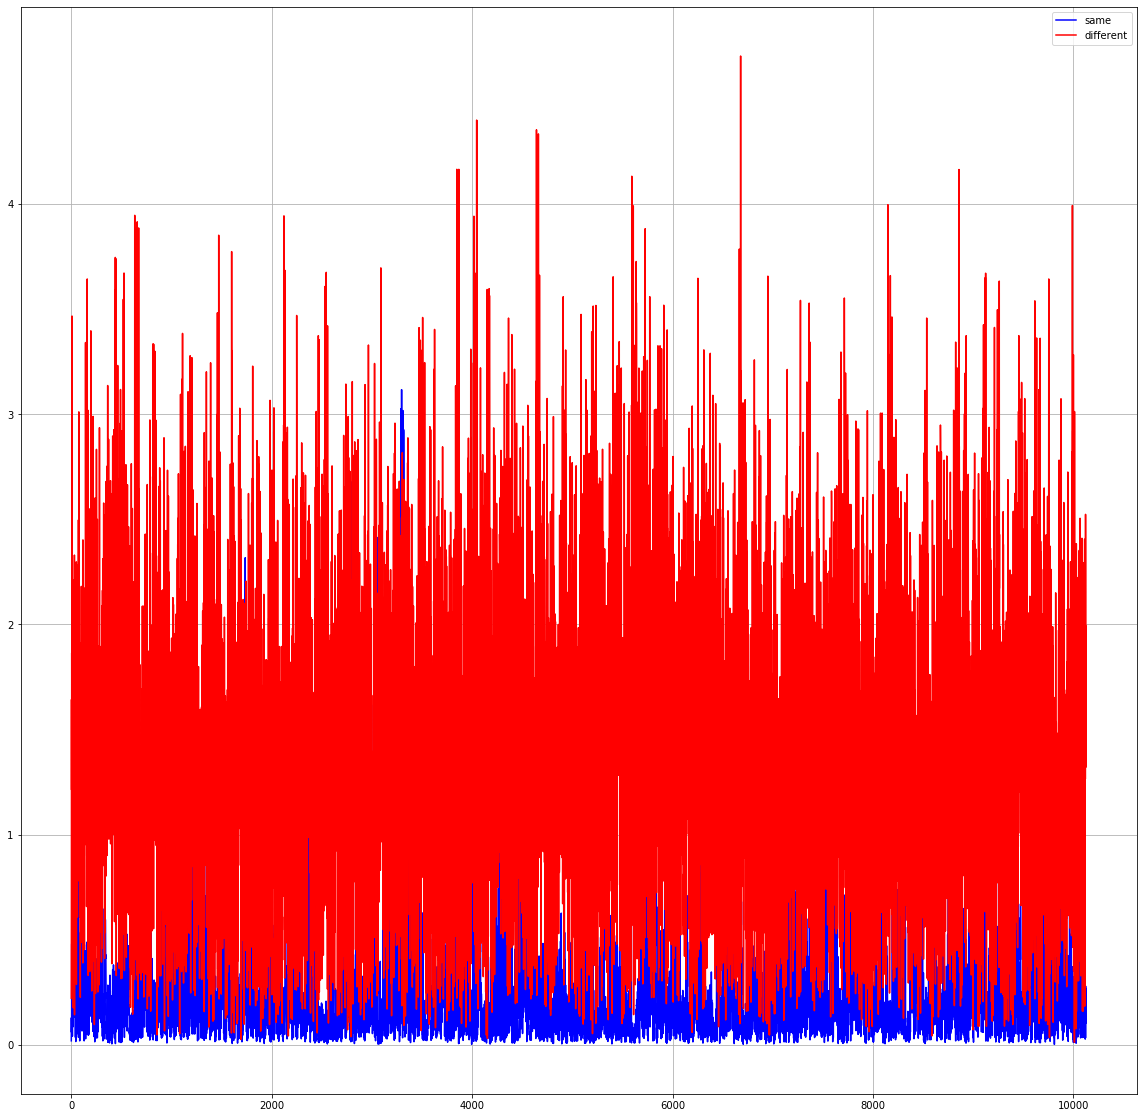

In [0]:
"""
Visualizing all the results from all the testing pairs
On the bottom a plot is demonstrated to see how the network diferentiated
positive from negative pairs
"""
plot_loss(history)
get_results_from_pairs(test_pairs, test_labels, model, threshold=0.8)

In [0]:
class ConvolutionalNeuralNetwork(Model):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = Conv2D(filters=32,
                            kernel_size=(3, 3),
                            padding='same',
                            activation='relu')
        self.conv2 = Conv2D(filters=32,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))
        self.conv3 = Conv2D(filters=64, 
                            kernel_size=(3, 3),
                            padding='same',
                            activation='relu')
        self.conv4 = Conv2D(filters=64,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))
        self.conv5 = Conv2D(filters=128,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.conv6 = Conv2D(filters=256,
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2))
        self.conv7 = Conv2D(filters=512,
                            kernel_size=(3, 3),
                            padding="same", 
                            activation="relu")
        self.conv8 = Conv2D(filters=512, 
                            kernel_size=(3, 3),
                            padding="same",
                            activation="relu")
        self.flatten = Flatten()
        self.dropout = Dropout(rate=0.5)
        self.dense1 = Dense(units=1024,
                            activation='relu')
        self.dense2 = Dense(units=1024,
                            activation='sigmoid')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x
    
class SiamesisNeuralNetwork:
    def __init__(self, datagen, input_shape, input_pairs, input_labels):
        self.datagen = datagen
        self.input_shape = input_shape
        self.input_pairs = input_pairs 
        self.input_labels = input_labels
        self.batch_size = 112
    
    def create_inputs(self, input_shape):
        return Input(shape=input_shape), Input(shape=input_shape)
    
    def create_outputs(self, input_top, input_bottom, network):
        return network(input_top), network(input_bottom)
    
    def euclidian_distance(self, vectors):
        v, u = vectors
        print(type(vectors), type(v), type(u))
        return (K.maximum(K.sum(K.square(v-u), axis=1, keepdims=True),
                         K.epsilon()))
    
    def calculate_distance(self, output_top, output_bottom):
        return Lambda(function=self.euclidian_distance,
                      output_shape=(1,))([output_top, output_bottom])
    
    def create_premodel(self, input_top, input_bottom, distance):
        return Model(inputs=[input_top, input_bottom], outputs=distance)
    
    def contrastive_loss(self, y_true, D, margin=1):
        return K.mean(y_true*K.square(D)+(1-y_true)*K.maximum((margin-D), 0))
    
    def config_backpropagation(self, premodel):
        premodel.compile(loss=self.contrastive_loss,
                         optimizer='adadelta')
        return premodel
    
    def fit_data(self, model):
        history = model.fit_generator(self.datagen.flow([input_pairs[:,0], input_pairs[:,1]],
                                                   input_labels,
                                                   batch_size=self.batch_size),
                                      steps_per_epoch=len(self.input_pairs)/self.batch_size,
                                      epochs=18)
        return model, history
    
    def train(self):
        input_top, input_bottom = self.create_inputs(self.input_shape)
        network = ConvolutionalNeuralNetwork()
        output_top, output_bottom = self.create_outputs(input_top, 
                                                        input_bottom,
                                                        network)
        distance = self.calculate_distance(output_top, output_bottom)
        premodel = self.create_premodel(input_top, input_bottom, distance)  
        model = self.config_backpropagation(premodel)
        return model, None
    
siams = SiamesisNeuralNetwork(datagen=1, input_shape=input_shape, input_pairs=1, input_labels=1)
model, history = siams.train()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<class 'list'> <class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>


In [0]:
fpath = "/content/gdrive/My Drive/weights_convlayers8_margin2_epochs18.h5"
model.load_weights(fpath)

In [0]:
allowed_imgs_s000 = [
    '/content/datasets/muct/muct0/i000qa-fn.jpg',
    '/content/datasets/muct/muct0/i000ra-fn.jpg',
    '/content/datasets/muct/muct0/i000sa-fn.jpg',
    '/content/datasets/muct/muct1/i000qb-fn.jpg',
    '/content/datasets/muct/muct1/i000rb-fn.jpg',
    '/content/datasets/muct/muct1/i000sb-fn.jpg',
    '/content/datasets/muct/muct2/i000qc-fn.jpg',
    '/content/datasets/muct/muct2/i000rc-fn.jpg',
    '/content/datasets/muct/muct2/i000sc-fn.jpg',
    '/content/datasets/muct/muct3/i000qd-fn.jpg',
    '/content/datasets/muct/muct3/i000rd-fn.jpg',
    '/content/datasets/muct/muct3/i000sd-fn.jpg',
    '/content/datasets/muct/muct4/i000qe-fn.jpg',
    '/content/datasets/muct/muct4/i000re-fn.jpg',
    '/content/datasets/muct/muct4/i000se-fn.jpg',
]

allowed_imgs_s001 = [
    '/content/datasets/muct/muct0/i001qa-mn.jpg',
    '/content/datasets/muct/muct0/i001ra-mn.jpg',
    '/content/datasets/muct/muct0/i001sa-mn.jpg',
    '/content/datasets/muct/muct1/i001qb-mn.jpg',
    '/content/datasets/muct/muct1/i001rb-mn.jpg',
    '/content/datasets/muct/muct1/i001sb-mn.jpg',
    '/content/datasets/muct/muct2/i001qc-mn.jpg',
    '/content/datasets/muct/muct2/i001rc-mn.jpg',
    '/content/datasets/muct/muct2/i001sc-mn.jpg',
    '/content/datasets/muct/muct3/i001qd-mn.jpg',
    '/content/datasets/muct/muct3/i001rd-mn.jpg',
    '/content/datasets/muct/muct3/i001sd-mn.jpg',
    '/content/datasets/muct/muct4/i001qe-mn.jpg',
    '/content/datasets/muct/muct4/i001re-mn.jpg',
    '/content/datasets/muct/muct4/i001se-m2.jpg',
]

allowed_imgs_s002 = [
    '/content/datasets/muct/muct0/i002qa-mn.jpg',
    '/content/datasets/muct/muct0/i002ra-mn.jpg',
    '/content/datasets/muct/muct0/i002sa-mn.jpg',
    '/content/datasets/muct/muct1/i002qb-mn.jpg',
    '/content/datasets/muct/muct1/i002rb-mn.jpg',
    '/content/datasets/muct/muct1/i002sb-mn.jpg',
    '/content/datasets/muct/muct2/i002qc-mn.jpg',
    '/content/datasets/muct/muct2/i002rc-mn.jpg',
    '/content/datasets/muct/muct2/i002sc-mn.jpg',
    '/content/datasets/muct/muct3/i002qd-mn.jpg',
    '/content/datasets/muct/muct3/i002rd-mn.jpg',
    '/content/datasets/muct/muct3/i002sd-mn.jpg',
    '/content/datasets/muct/muct4/i002qe-mn.jpg',
    '/content/datasets/muct/muct4/i002re-mn.jpg',
    '/content/datasets/muct/muct4/i002se-mn.jpg',
]

allowed_imgs_s200 = [
    '/content/datasets/muct/muct0/i200ta-mg.jpg',
    '/content/datasets/muct/muct0/i200ua-mg.jpg',
    '/content/datasets/muct/muct0/i200va-mg.jpg',
    '/content/datasets/muct/muct1/i200tb-mg.jpg',
    '/content/datasets/muct/muct1/i200ub-mg.jpg',
    '/content/datasets/muct/muct1/i200vb-mg.jpg',
    '/content/datasets/muct/muct2/i200tc-mg.jpg',
    '/content/datasets/muct/muct2/i200uc-mg.jpg',
    '/content/datasets/muct/muct2/i200vc-mg.jpg',
    '/content/datasets/muct/muct3/i200td-mg.jpg',
    '/content/datasets/muct/muct3/i200ud-mg.jpg',
    '/content/datasets/muct/muct3/i200vd-mg.jpg',
    '/content/datasets/muct/muct4/i200te-mg.jpg',
    '/content/datasets/muct/muct4/i200ue-mg.jpg',
    '/content/datasets/muct/muct4/i200ve-mg.jpg',
]

allowed_imgs_s201 = [
    '/content/datasets/muct/muct0/i201ta-mg.jpg',
    '/content/datasets/muct/muct0/i201ua-mg.jpg',
    '/content/datasets/muct/muct0/i201va-mg.jpg',
    '/content/datasets/muct/muct1/i201tb-mg.jpg',
    '/content/datasets/muct/muct1/i201ub-mg.jpg',
    '/content/datasets/muct/muct1/i201vb-mg.jpg',
    '/content/datasets/muct/muct2/i201tc-mg.jpg',
    '/content/datasets/muct/muct2/i201uc-mg.jpg',
    '/content/datasets/muct/muct2/i201vc-mg.jpg',
    '/content/datasets/muct/muct3/i201td-mg.jpg',
    '/content/datasets/muct/muct3/i201ud-mg.jpg',
    '/content/datasets/muct/muct3/i201vd-mg.jpg',
    '/content/datasets/muct/muct4/i201te-mg.jpg',
    '/content/datasets/muct/muct4/i201ue-mg.jpg',
    '/content/datasets/muct/muct4/i201ve-m1.jpg',
]

allowed_imgs_s400 = [
    '/content/datasets/muct/muct0/i400wa-mn.jpg',
    '/content/datasets/muct/muct0/i400xa-mn.jpg',
    '/content/datasets/muct/muct1/i400wb-mn.jpg',
    '/content/datasets/muct/muct1/i400xb-mn.jpg',
    '/content/datasets/muct/muct2/i400wc-mn.jpg',
    '/content/datasets/muct/muct2/i400xc-mn.jpg',
    '/content/datasets/muct/muct3/i400wd-mn.jpg',
    '/content/datasets/muct/muct3/i400xd-mn.jpg',
    '/content/datasets/muct/muct4/i400we-mn.jpg',
    '/content/datasets/muct/muct4/i400xe-mn.jpg',
]

allowed_imgs_s401 = [
    '/content/datasets/muct/muct0/i401wa-fn.jpg',
    '/content/datasets/muct/muct0/i401xa-fn.jpg',
    '/content/datasets/muct/muct1/i401wb-fn.jpg',
    '/content/datasets/muct/muct1/i401xb-fn.jpg',
    '/content/datasets/muct/muct2/i401wc-fn.jpg',
    '/content/datasets/muct/muct2/i401xc-fn.jpg',
    '/content/datasets/muct/muct3/i401wd-fn.jpg',
    '/content/datasets/muct/muct3/i401xd-fn.jpg',
    '/content/datasets/muct/muct4/i401we-fn.jpg',
    '/content/datasets/muct/muct4/i401xe-fn.jpg',
]

In [0]:
pos_pairs = [
    (allowed_imgs_s000[0], allowed_imgs_s000[1]),
    (allowed_imgs_s000[2], allowed_imgs_s000[3]),
    (allowed_imgs_s000[4], allowed_imgs_s000[5]),
    (allowed_imgs_s001[0], allowed_imgs_s001[1]),
    (allowed_imgs_s001[2], allowed_imgs_s001[3]),
    (allowed_imgs_s001[4], allowed_imgs_s001[5]),
    (allowed_imgs_s002[0], allowed_imgs_s002[1]),
    (allowed_imgs_s002[2], allowed_imgs_s002[3]),
    (allowed_imgs_s002[4], allowed_imgs_s002[6]),
]

In [0]:
neg_pairs = [
    (allowed_imgs_s000[0], allowed_imgs_s001[0]),
    (allowed_imgs_s000[1], allowed_imgs_s002[1]),
    (allowed_imgs_s000[2], allowed_imgs_s400[0]),
    (allowed_imgs_s001[0], allowed_imgs_s000[3]),
    (allowed_imgs_s001[2], allowed_imgs_s002[4]),
    (allowed_imgs_s001[2], allowed_imgs_s400[5]),
    (allowed_imgs_s002[0], allowed_imgs_s000[1]),
    (allowed_imgs_s002[1], allowed_imgs_s001[7]),
    (allowed_imgs_s002[2], allowed_imgs_s400[8]),
]

In [0]:
def test_allowed_pair(pair, face_detector, model):
    imgpath1, imgpath2 = pair
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
    for index in range(2):
        ax[index].set_xticks([])
        ax[index].set_yticks([])
    face_imgpath1 = detect_face(imgpath1, face_detector)
    img1 = load_img(
        path=face_imgpath1,
        color_mode="rgb",
        interpolation="hamming",
    )
    ax[0].imshow(img1)
    img1 = load_img(
        path=face_imgpath1,
        color_mode="grayscale",
        interpolation="hamming",
        target_size=(img_height, img_width)
    )
    img1 = img_to_array(img1).astype('float32') / 255
    img1 = img1.reshape((1,) + img1.shape)
    face_imgpath2 = detect_face(imgpath2, face_detector)
    img2 = load_img(
        path=face_imgpath2,
        color_mode="rgb",
        interpolation="hamming",
    )
    ax[1].imshow(img2)
    img2 = load_img(
        path=face_imgpath2,
        color_mode="grayscale",
        interpolation="hamming",
        target_size=(img_height, img_width)
    )
    img2 = img_to_array(img2).astype('float32') / 255
    img2 = img2.reshape((1,) + img2.shape)
    dist = model.predict([img1, img2])[0][0]
    dist = str(dist)
    dist = dist.replace('.', ',')
    fig.suptitle(f"Distância = {dist[:4]}", y=0.73, fontsize=18)

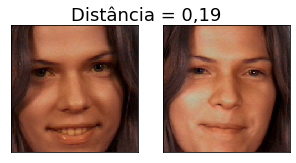

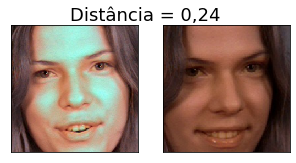

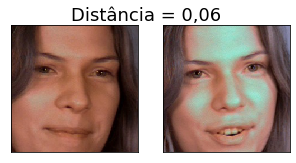

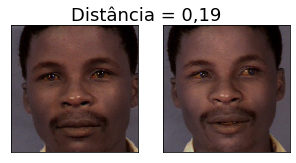

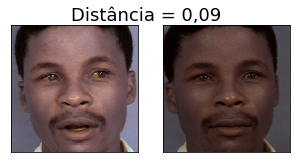

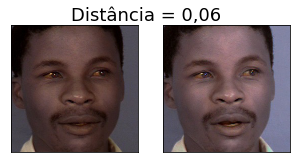

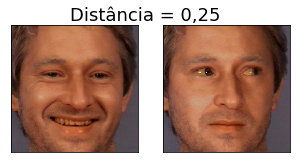

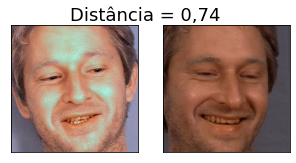

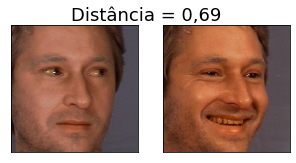

In [0]:
for index in range(9):
    test_allowed_pair(pos_pairs[index], face_detector, model)

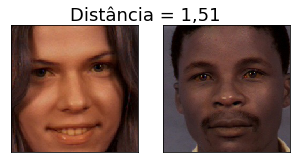

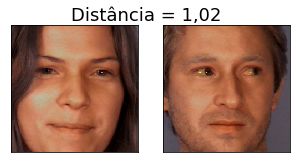

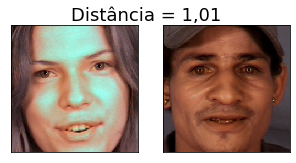

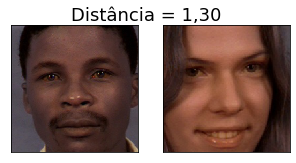

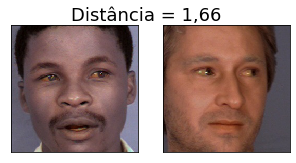

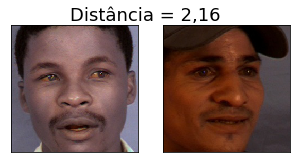

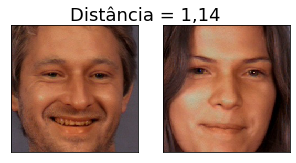

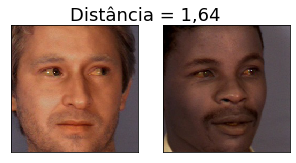

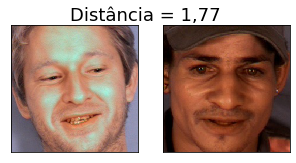

In [0]:
for index in range(9):
    test_allowed_pair(neg_pairs[index], face_detector, model)